## Machine Learning to Classify Autistic Childrens Based on Normal Pictures

In [1]:
import sys
print(f"Python version is {sys.version}")
import os
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
print(f"tensorflow version is {tf.__version__}")

Python version is 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
tensorflow version is 2.19.0


In [2]:
# import data
images = []
labels = []

data_dir = 'autism_face_library'
IMG_SIZE = (128, 128) 

Start = time.time()

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        filepath = os.path.join(data_dir, filename)
        if filename.startswith('Autistic'):
            label = 1 # ASD kids labeled 1
        elif filename.startswith('Non_Autistic'):
            label = 0 # Non-ASD kids labeled 0
        else:
            continue  
        
        try:
            img = Image.open(filepath).convert('RGB')
            img = img.resize(IMG_SIZE) # standardize the image size to (128, 128)
            img_array = np.array(img)

            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

print(f"Data import completed. It totally takes {time.time() - Start} seconds.")

Data import completed. It totally takes 6.275755167007446 seconds.


In [3]:
# Convert data lists to Arrays
X = np.array(images)
y = np.array(labels)
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)

Image data shape: (2940, 128, 128, 3)
Labels shape: (2940,)


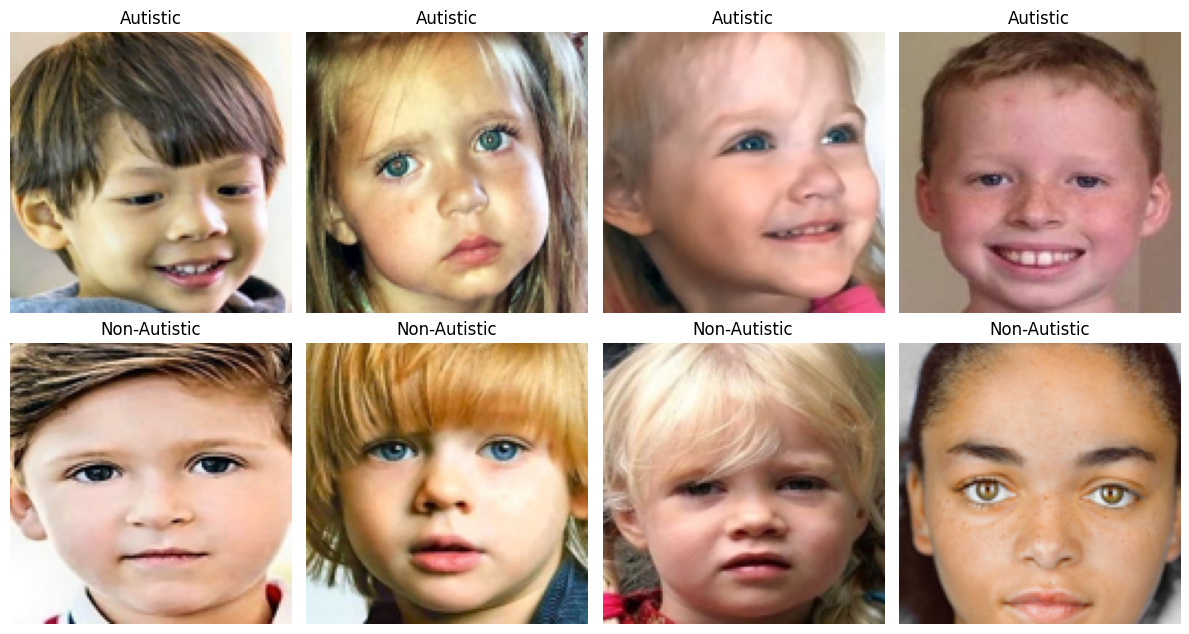

In [4]:
# show example images
plt.figure(figsize=(12, 6.5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X[i*368+6])
    plt.title("Autistic" if y[i*368+6] == 1 else "Non-Autistic")
    plt.axis('off')

plt.tight_layout()
plt.savefig("Figure_A Example Facial Images.png", dpi=300, bbox_inches='tight')
plt.show()

### VGG16 Model Fitting and Evaluation

In [5]:
# ensure reproducibility
SEED = 50
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# os.environ['TF_DETERMINISTIC_OPS'] = '1'   # Force deterministic ops
# os.environ['PYTHONHASHSEED'] = str(SEED)
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.threading.set_intra_op_parallelism_threads(1)

# 1. Preparing the format of labels: One-hot encode labels 
# binary classification: 0 = Non-Autistic, 1 = Autistic
y_cat = to_categorical(y, num_classes=2)

# 2. Preprocess input for VGG16
# This data preprocessing is model specific
# It prepares the images to a format that matches with the data that VGG16 was trained on. 
# The preprocessing include (1) converting RGB pixels from 255 range to centered (subtracting) 
# at [103.939, 116.779, 123.68]
# These centers are the mean RGB values from ImageNet database, with which the VGG16 was originally trained on. 
# And (2) the color channel converted from RGB to BGR format
X_prep = preprocess_input(X)

# 3. Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_cat, test_size=0.2, stratify=y, random_state=SEED)

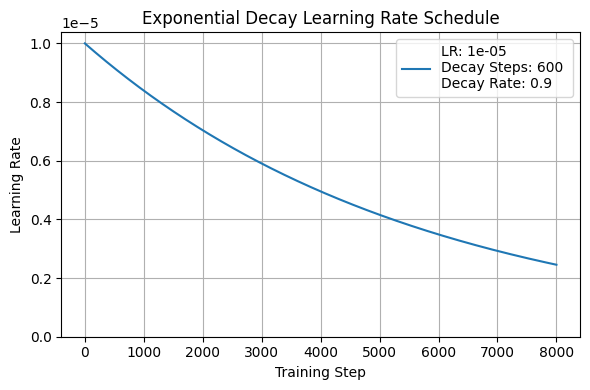

In [6]:
# 4. Load VGG16
#  Input shape is set to match the resized images
base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_shape=(128, 128, 3))

# Freeze base model layers but unfreeze the last few layers 
for layer in base_model.layers:
    layer.trainable = False
# unfreeze the last 5 layers: 
# reasoning: the dataset is small, similar to ImageNet, but different
# small dataset and similar to ImageNet - freeze all layers
# large dataset and different from ImageNet - unfreeze all layers
for layer in base_model.layers[-5:]:
    layer.trainable = True

# 5. Add classifier to the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')])  # 2 classes: ASD and non ASD

# 6. Compile model
# model.compile(optimizer=Adam(learning_rate=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Constant Learning Rate
# model.compile(optimizer=Adam(learning_rate=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Exponential Decay Scheduler Learning Rate
initial_lr = 1e-5 
decay_steps = 600 
decay_rate =0.9 
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps,
                               decay_rate=decay_rate,
                               staircase=False) # staircase=True: Discrete drop every 300 steps
                                                # staircase = False: continuous decay at every step

steps = np.arange(0, 8001)
lrs = [lr_schedule(step).numpy() for step in steps]

plt.figure(figsize=(6, 4))
plt.plot(steps, lrs, label=f'LR: {initial_lr} \nDecay Steps: {decay_steps} \nDecay Rate: {decay_rate}')
plt.title('Exponential Decay Learning Rate Schedule')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),  # <-- CHANGED
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model Training: 

Training process results, such as accuracy and loss per epoch, are saved in a variable called "history". 

validation_split=0.2: Before training the model, the data were randomly shuffled and split 80-20: 80% is used for model training and 20% used for validation to avoid overfitting. These 20% data are used to evaluates the model fitting at the end of each epoch and to calculate metrics like val_loss and val_accuracy. It also used to trigger EarlyStopping (with either val_loss or val_accuracy based on EarlyStopping setup). 

epochs=100: the maximum number of training cycles (epochs) is set to 100, if training is not stopped early by EarlyStopping criteria. Each epoch is considered the model sees the entire training data once. 

batch_size=32: The model processes 32 images at a time before updating weights; smaller batches results in slower training but potentially more stable training. 32 is a common used default in VGG16 model. 

For example, the full dataset is 2940 images. The whole training set is 2352 images (80% for training and 20% for testing, split above in cell #5). Before model training, the data is split 80-20 again for training and validation; so 1882 images used in model training and 470 used for validation. Batch size is 32 so we will have 1882/32 = 58.8 or 59 batches. 

So, training the model: there are maximum 100 cycles (epochs). In each epoch, the model process 59 batches (32 image per batch) to update the weight (after each batch). After all 59 batches completed, the model used validation set to evaluate the model. If validation passes, the model will start the next epoch. 

callbacks=[early_stop]: use the early stopping criteria defined in step 7.

In [8]:
# 7. Train model with early stopping
# early stopping by val_loss (default)
# early_stop = EarlyStopping(patience=20, restore_best_weights=True)
# # early stopping by val_accuracy
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, mode='max', restore_best_weights=True)

class PrintLearningRate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        # If lr is a schedule (like ExponentialDecay), evaluate it
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_lr = lr(self.model.optimizer.iterations).numpy()
        else:
            current_lr = lr.numpy()
        print(f"\nEpoch {epoch + 1}: Learning rate = {current_lr:.8f}")

Start = time.time()

history = model.fit(
    X_train, y_train,
    validation_split = 0.2, # take 20% of the training data and use it as a validation set during training
    epochs = 200,
    batch_size = 64,
    callbacks=[PrintLearningRate(), early_stop],
    verbose = 1
)

print(f"\nModel fitting completed. It totally takes {time.time() - Start} seconds.")

val_acc = history.history['val_accuracy']
print("\nBest validation accuracy:", max(val_acc))

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4836 - loss: 3.4941 - precision: 0.4836 - recall: 0.4836
Epoch 1: Learning rate = 0.00000995
30/30 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.4848 - loss: 3.4641 - precision: 0.4848 - recall: 0.4848 - val_accuracy: 0.6433 - val_loss: 0.7610 - val_precision: 0.6433 - val_recall: 0.6433
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5259 - loss: 1.2806 - precision: 0.5259 - recall: 0.5259
Epoch 2: Learning rate = 0.00000990
30/30 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.5269 - loss: 1.2740 - precision: 0.5269 - recall: 0.5269 - val_accuracy: 0.6285 - val_loss: 0.6657 - val_precision: 0.6285 - val_recall: 0.6285
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5841 - loss: 0.8305 - precision: 0.5841 - recall: 0.5841
Epoch 3: Learning rate = 0.00000984
30/30 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.5841 - loss: 0.8302 - precision: 0.5841 - recall: 0.5841 - val_accuracy: 0.6348

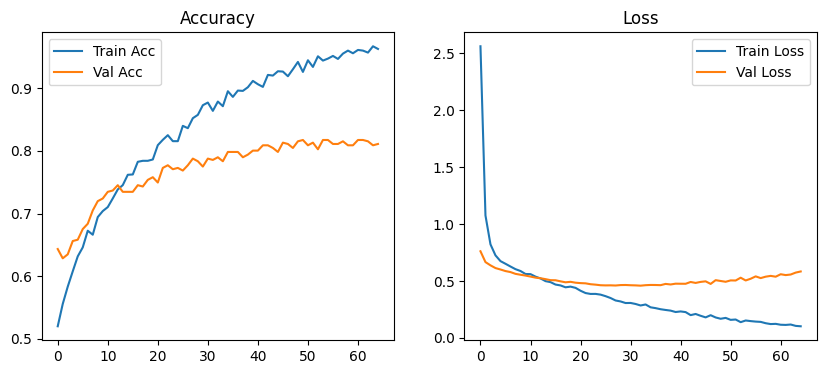

In [9]:
# 8. Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [10]:
# 9. Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict class probabilities
y_prob = model.predict(X_test)

# Convert one-hot encoded labels to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)

label_map = {0: 'Non-Autistic', 1: 'Autistic'}
class_names = [label_map[i] for i in range(len(label_map))]

print(classification_report(y_true, y_pred, target_names=class_names))

Test Accuracy: 0.8095
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
              precision    recall  f1-score   support

Non-Autistic       0.81      0.81      0.81       294
    Autistic       0.81      0.81      0.81       294

    accuracy                           0.81       588
   macro avg       0.81      0.81      0.81       588
weighted avg       0.81      0.81      0.81       588



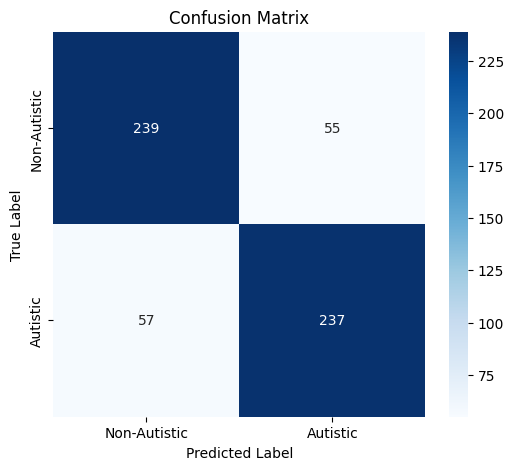

In [11]:
# Confusion matrix on test set
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

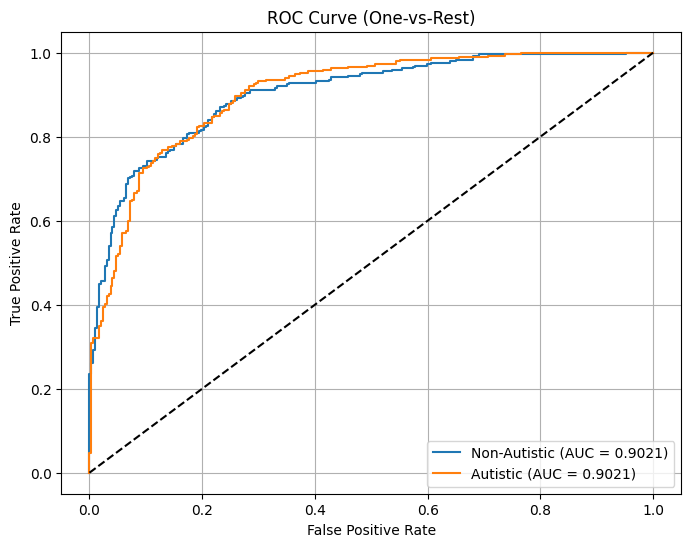

In [12]:
# ROC Curve
n_classes = y_test.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()